In [1]:
import os, sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#ACOLLINEARITY FUNCTION
def angleacoll(th1,th2,ph1,ph2):
    v1=[np.sin(th1)*np.cos(ph1),np.sin(th1)*np.sin(ph1),np.cos(th1)]
    v2=[np.sin(th2)*np.cos(ph2),np.sin(th2)*np.sin(ph2),np.cos(th2)]
    dot = np.dot(v1,v2)
    return (abs(np.pi-np.arccos(dot)))


In [4]:
backgrounds = ['eeqq','qq','wen','ww','zee','zz']
backgrounds_cs = [15600,102,2.90,16.5,3.35,0.975] #pb
signals = ['higgs_85','higgs_90','higgs_95']
signal_cs = [0.0940,0.0667,0.0333] #pb
data = ['data']



#concatenate all the channels
channels = backgrounds + signals + data
xsections = backgrounds_cs + signal_cs

#list which takes into account whether the channel is a background (bkg), signal (sgn), or data (data)
bkgsigdata = []

#dataframes lists
df_names = [] #need to work with names instead of just df because python cannot find a dataframe in a list of dataframes, so i just search by name
df_list = []
df_list_cut = []


for channel in channels:
    #fill the dataframes
    filename = './l3higgs189/higgs_' + channel + '.csv'
    dfname = 'df_' + channel
    vars()[dfname] = pd.read_csv(filename)
    
    #acollinearity #TODO: PHI?
    #(vars()[dfname])['acoll'] = (vars()[dfname])['thj1']-(vars()[dfname])['thj2']
    
    #add xmj1+xmj2 column (probably will need it for a cut)
    (vars()[dfname])['xmj1p2'] = (vars()[dfname])['xmj1']+(vars()[dfname])['xmj2']
    
    #add recoiling mass against jets
    angle = 90
    recmass = []
    acollin = []
    for index, row in (vars()[dfname]).iterrows():
        #recoil mass
        recoilmass=0
        theta_jets = (row['xmj1']*row['thj1']+row['xmj2']*row['thj2'])/(row['xmj1']+row['xmj2'])
        phi_jets = (row['xmj1']*row['phj1']+row['xmj2']*row['phj2'])/(row['xmj1']+row['xmj2'])
        if ((row['ele_phi'] < phi_jets+180+angle) and (row['ele_phi'] > phi_jets+180-angle) and (row['ele_the'] < theta_jets+180+angle) and (row['ele_the'] > theta_jets+180-angle)):
            recoilmass += 0.000511*row['ele_num']
        if ((row['muon_phi'] < phi_jets+180+angle) and (row['muon_phi'] > phi_jets+180-angle) and (row['muon_the'] < theta_jets+180+angle) and (row['muon_the'] > theta_jets+180-angle)):
            recoilmass += 0.105*row['muon_num']
        recmass.append(recoilmass)
        #acollinearity
        acollin.append(angleacoll(row['thj1'],row['thj2'],row['phj1'],row['phj2']))
        
        
    (vars()[dfname])['rec_mass'] = recmass
    (vars()[dfname])['acoll'] = acollin
        
    
    
    #fill the bkgsigdata list, categorizing bkg, sgn, data
    if channel in backgrounds:
        bkgsigdata.append('bkg')
    elif channel in signals:
        bkgsigdata.append('sgn')
    elif channel in data:
        bkgsigdata.append('data')
        
    #fill dataframes lists
    df_names.append(dfname)
    df_list.append(vars()[dfname])
    

In [5]:
#function that finds number of events in dataframe
#it identifies an events by pair event number and run number
def n_events(df):
    sumev = 0
    for item in df.groupby(['ievt', 'irun']).size():
        sumev = sumev + item
    return sumev

#find corresponding cross section given the channel
def dfxsec(dfname, df_names):
    index = df_names.index(dfname)
    return xsections[index]

#find scale factor by which each channel needs to be multiplied to match data
def scalefactor(lumi, n_events, xsec):
    return (xsec*lumi)/n_events




In [7]:
#normalize everything for the cross sections and luminosity
int_lumi = 176.773 #pb^-1

for dfname in df_names:
    if dfname != 'df_data':
        index = df_names.index(dfname)
        print(scalefactor(int_lumi, n_events(df_list[index]), dfxsec(dfname, df_names)))

32443.044705882352
5.952738857708815
0.06525479887983707
0.11051661488329798
2.5525411637931037
0.004791328672300678
0.004955759618252311
0.0034709329113924046
0.0017603292165071774


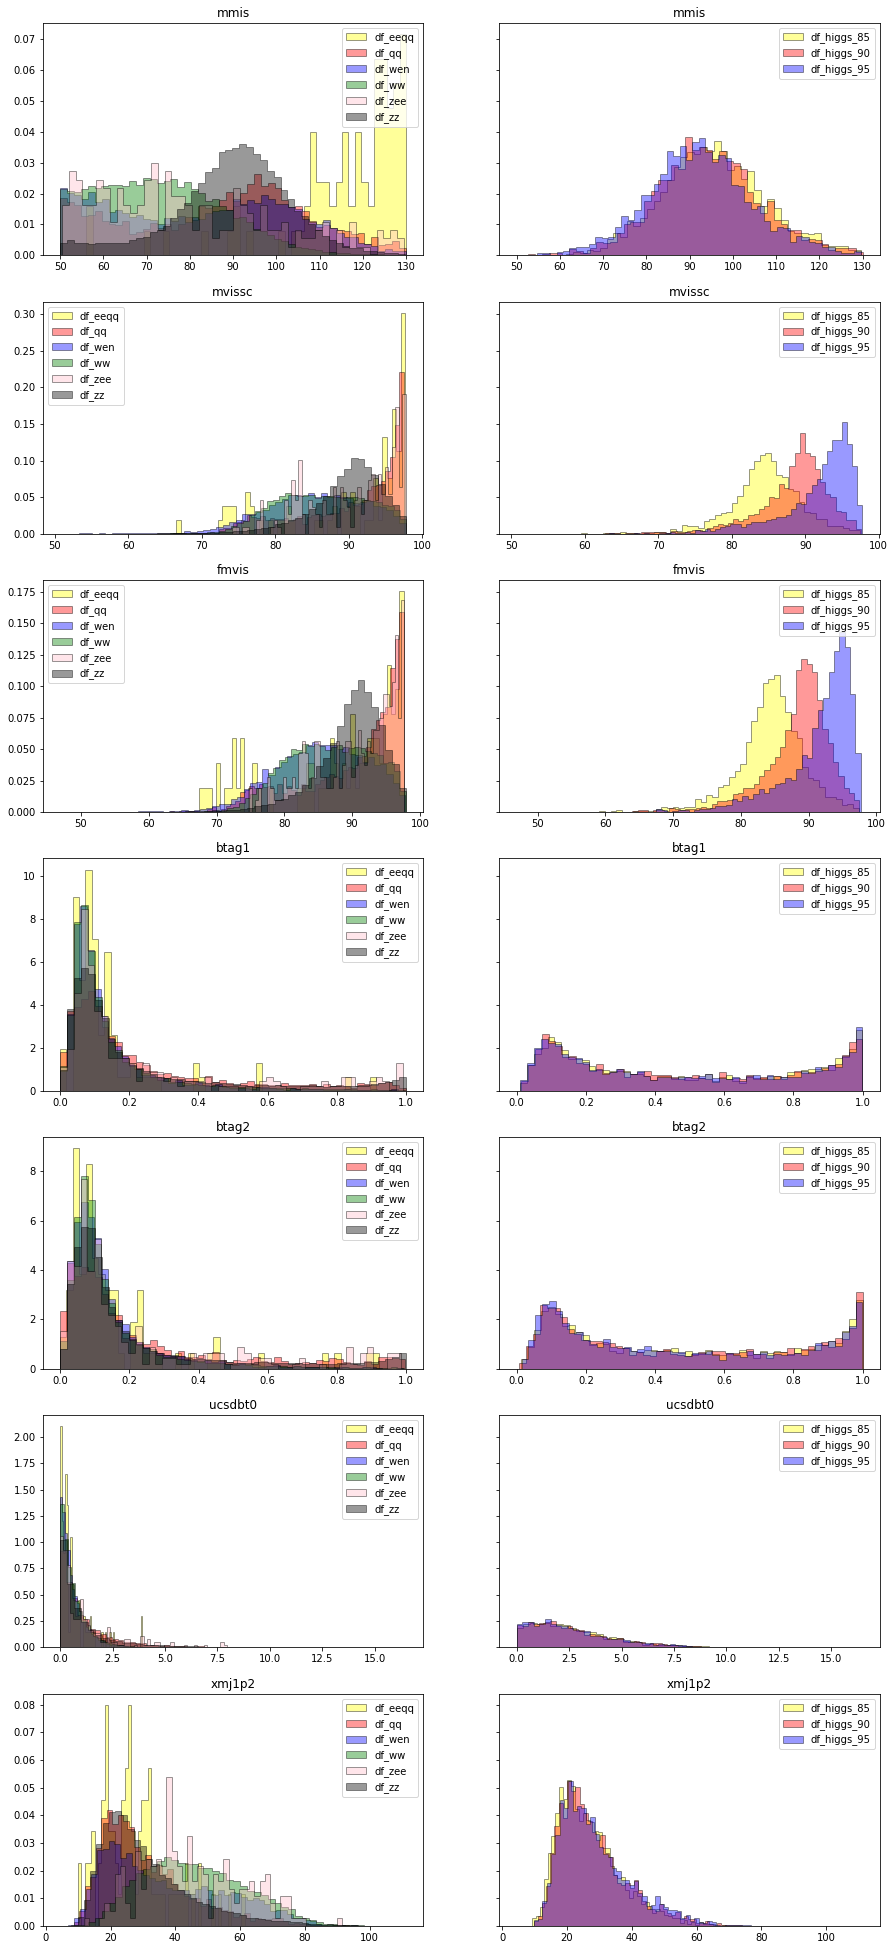

In [8]:
#check variables for each channel, try to make some sense out of them and try to see possible cuts
varlist = ['mmis', 'mvissc', 'fmvis', 'btag1', 'btag2', 'ucsdbt0','xmj1p2' ]
#varlist = ['mmis', 'pho_ene']
varlength = len(varlist)

colors = ['yellow', 'red', 'blue', 'green', 'pink', 'black']
bins = 50

#plot each variable on each row
#left background, right signal(s)

f, axs = plt.subplots(varlength, 2, sharey='row', sharex='row', figsize=(15,varlength*5))

for varname in varlist:
    index_var = varlist.index(varname)
    for dfname in df_names:
        index = df_names.index(dfname)
        
        #backgrounds
        if bkgsigdata[index] == 'bkg':
            #plot histograms (normalised area to 1)
            axs[index_var,0].hist((df_list[index])[varname], bins=bins, color=colors[index%len(colors)], ec="black", histtype="stepfilled", label=dfname, alpha=0.4, density=True)
            
            #calculate scale factor (xs) and plot histograms
            scalef = scalefactor(int_lumi, n_events(df_list[index]), dfxsec(dfname, df_names))
            weights = scalef*np.ones_like(np.linspace(1,n_events(df_list[index]), n_events(df_list[index])))
            #axs[index_var,0].hist(((df_list[index])[varname]), bins=bins, weights=weights, color=colors[index%len(colors)], ec="black", histtype="stepfilled", label=dfname, alpha=0.4)
        
        #signals
        if bkgsigdata[index] == 'sgn':
            #plot histograms (normalised area to 1)
            axs[index_var,1].hist((df_list[index])[varname], bins=bins, color=colors[index%len(colors)], ec="black", histtype="stepfilled", label=dfname, alpha=0.4, density=True)

            #calculate scale factor (xs) and plot histograms
            scalef = scalefactor(int_lumi, n_events(df_list[index]), dfxsec(dfname, df_names))
            weights = scalef*np.ones_like(np.linspace(1,n_events(df_list[index]), n_events(df_list[index])))
            #axs[index_var,1].hist(((df_list[index])[varname]), bins=bins, weights=weights, color=colors[index%len(colors)], ec="black", histtype="stepfilled", label=dfname, alpha=0.4)
    
    #plot title and legend for background (left) and signal (right)
    axs[index_var,0].set_title(varname)
    axs[index_var,0].legend(loc='best')
    axs[index_var,1].set_title(varname)
    axs[index_var,1].legend(loc='best')

plt.show()

In [ ]:
#to do: add signal + background and compare to data, see if it matches (normalising)

In [35]:
#df_list_cut[1][df_list_cut[1]['acoll']<1.4/6.5]

n_events(df_list_cut[1])

1158

0.0
0.05
0.1
0.15000000000000002
0.2
0.25
0.30000000000000004
0.35000000000000003
0.4
0.45
0.5
0.55
0.6000000000000001
0.65
0.7000000000000001
0.75
0.8
0.8500000000000001
0.9
0.9500000000000001
1.0


/home/pipsini/Programs/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:103: RuntimeWarning: invalid value encountered in double_scalars
/home/pipsini/Programs/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:104: RuntimeWarning: invalid value encountered in double_scalars
/home/pipsini/Programs/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:105: RuntimeWarning: invalid value encountered in double_scalars


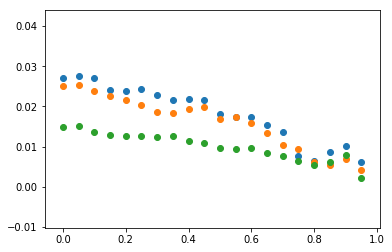

In [113]:
#check variables for each channel, try to make some sense out of them and try to see possible cuts
varlist = ['btag1', 'btag2', 'xmj1p2', 'ucsdbt0', 'mmis','acoll']
varlength = len(varlist)

colors = ['yellow', 'red', 'blue', 'green', 'pink', 'black']
bins = 50

#plot each variable on each row
#left background, right signal(s)
df_list_cut = []

eff_85 = []
eff_90 = []
eff_95 = []


'''#btag
xrange_btag = np.linspace(0,1,21)
#angle
xrange_angle = np.linspace(0,90,19)
#ucsdbt0
xrange_bts = np.linspace(0,14,30)
#xmj1p2
xrange_xmj = np.linspace(10,100,10)'''


#btag
xrange_btag = np.linspace(0,1,2)
#angle
xrange_angle = np.linspace(0,90,2)
#ucsdbt0
xrange_bts = np.linspace(0,14,2)
#xmj1p2
xrange_xmj = np.linspace(10,100,2)


maxeff85 = -1
bestcuts85 = []
maxeff90 = -1
bestcuts90 = []
maxeff95 = -1
bestcuts95 = []


for anglesaxon in xrange_angle:
    df_list_cut = []
    #f, axs = plt.subplots(varlength, 2, sharey='row', sharex='row', figsize=(15,varlength*5))

    for dfname in df_names:
        index = df_names.index(dfname)
        tmpdf = (df_list[index])[(df_list[index])['btag1'] > btagg]
        tmpdf = tmpdf[tmpdf['btag2'] > btagg]
        tmpdf = tmpdf[tmpdf['ucsdbt0'] >2.5]
        tmpdf = tmpdf[tmpdf['xmj1p2'] >40]
        tmpdf = tmpdf[tmpdf['acoll'] < anglesaxon*np.pi/180]
        df_list_cut.append(tmpdf)


    pumpsignal = 100    
    nevents = [0]*len(df_list)


    for varname in varlist:
        index_var = varlist.index(varname)
        for dfname in df_names:
            index = df_names.index(dfname)

            #backgrounds
            if bkgsigdata[index] == 'bkg':
                #plot histograms (normalised area to 1)
                #axs[index_var,0].hist((df_list_cut[index])[varname], bins=bins, color=colors[index%len(colors)], ec="black", histtype="stepfilled", label=dfname, alpha=0.4)
                if(n_events(df_list_cut[index]) != 0):
                    #calculate scale factor (xs) and plot histograms
                    scalef = scalefactor(int_lumi, n_events(df_list[index]), dfxsec(dfname, df_names))
                    weights = scalef*np.ones_like(np.linspace(1,n_events(df_list_cut[index]), n_events(df_list_cut[index])))
                    #axs[index_var,0].hist(((df_list_cut[index])[varname]), bins=bins, weights=weights, color=colors[index%len(colors)], ec="black", histtype="stepfilled", label=dfname, alpha=0.4)
                    nevents[index]=((n_events(df_list_cut[index]))*scalef)
                else: 
                    nevents[index]=0

            #signals
            if bkgsigdata[index] == 'sgn':
                #plot histograms (normalised area to 1)
                #axs[index_var,1].hist((df_list_cut[index])[varname], bins=bins, color=colors[index%len(colors)], ec="black", histtype="stepfilled", label=dfname, alpha=0.4)

                #calculate scale factor (xs) and plot histograms
                if(n_events(df_list_cut[index]) != 0):
                    scalef = pumpsignal*scalefactor(int_lumi, n_events(df_list[index]), dfxsec(dfname, df_names))
                    weights = scalef*np.ones_like(np.linspace(1,n_events(df_list_cut[index]), n_events(df_list_cut[index])))
                    #axs[index_var,1].hist(((df_list_cut[index])[varname]), bins=bins, weights=weights, color=colors[index%len(colors)], ec="black", histtype="stepfilled", label=dfname, alpha=0.4)
                    nevents[index]=((n_events(df_list_cut[index]))*scalef)
                else: 
                    nevents[index] = 0
        #plot title and legend for background (left) and signal (right)
        #axs[index_var,0].set_title(varname)
        #axs[index_var,0].legend(loc='best')
        #axs[index_var,1].set_title(varname)
        #axs[index_var,1].legend(loc='best')

    #plt.show()


    bkg_ev = 0
    sgn_ev_85 = 0
    sgn_ev_90 = 0
    sgn_ev_95 = 0

    for nev in nevents:
        index = nevents.index(nev)
        if bkgsigdata[index] == 'bkg':
            bkg_ev+=nev
        elif bkgsigdata[index] == 'sgn':
            if index == 6:
                sgn_ev_85+=nev/pumpsignal
            elif index == 7:
                sgn_ev_90+=nev/pumpsignal
            elif index == 8:
                sgn_ev_95+=nev/pumpsignal

    #print(sgn_ev_85, bkg_ev)
    #print(sgn_ev_90, bkg_ev)
    #print(sgn_ev_95, bkg_ev)

    eff_85.append(sgn_ev_85/np.sqrt(bkg_ev))
    eff_90.append(sgn_ev_90/np.sqrt(bkg_ev))
    eff_95.append(sgn_ev_95/np.sqrt(bkg_ev))

    '''print(sgn_ev_85/np.sqrt(bkg_ev))
    print(sgn_ev_90/np.sqrt(bkg_ev))
    print(sgn_ev_95/np.sqrt(bkg_ev))'''
    
    
plt.scatter(xrange,eff_85)
plt.scatter(xrange,eff_90)
plt.scatter(xrange,eff_95)

plt.show()


In [125]:
#check variables for each channel, try to make some sense out of them and try to see possible cuts
varlist = ['btag1', 'btag2', 'xmj1p2', 'ucsdbt0', 'mmis','acoll']
varlength = len(varlist)

colors = ['yellow', 'red', 'blue', 'green', 'pink', 'black']
bins = 50

#plot each variable on each row
#left background, right signal(s)
df_list_cut = []

eff_85 = []
eff_90 = []
eff_95 = []


'''#btag
xrange_btag = np.linspace(0,1,21)
#angle
xrange_angle = np.linspace(0,90,19)
#ucsdbt0
xrange_bts = np.linspace(0,14,30)
#xmj1p2
xrange_xmj = np.linspace(10,100,10)'''


#btag
xrange_btag = np.linspace(0,1,5)
#angle
xrange_angle = np.linspace(0,90,5)
#ucsdbt0
xrange_bts = np.linspace(0,14,5)
#xmj1p2
xrange_xmj = np.linspace(10,100,5)


maxeff85 = -1
bestcuts85 = []
maxeff90 = -1
bestcuts90 = []
maxeff95 = -1
bestcuts95 = []

start = time.time()

for anglesaxon in xrange_angle:
    print(anglesaxon)
    for btagg in xrange_btag:
        for ucsdbt00 in xrange_bts:
            for xmjj in xrange_xmj:
                df_list_cut = []
                #f, axs = plt.subplots(varlength, 2, sharey='row', sharex='row', figsize=(15,varlength*5))

                for dfname in df_names:
                    index = df_names.index(dfname)
                    tmpdf = (df_list[index])[(df_list[index])['btag1'] > btagg]
                    tmpdf = tmpdf[tmpdf['btag2'] > btagg]
                    tmpdf = tmpdf[tmpdf['ucsdbt0'] >2.5]
                    tmpdf = tmpdf[tmpdf['xmj1p2'] >40]
                    tmpdf = tmpdf[tmpdf['acoll'] < anglesaxon*np.pi/180]
                    df_list_cut.append(tmpdf)


                pumpsignal = 100    
                nevents = [0]*len(df_list)


                for varname in varlist:
                    index_var = varlist.index(varname)
                    for dfname in df_names:
                        index = df_names.index(dfname)

                        #backgrounds
                        if bkgsigdata[index] == 'bkg':
                            #plot histograms (normalised area to 1)
                            #axs[index_var,0].hist((df_list_cut[index])[varname], bins=bins, color=colors[index%len(colors)], ec="black", histtype="stepfilled", label=dfname, alpha=0.4)
                            if(n_events(df_list_cut[index]) != 0):
                                #calculate scale factor (xs) and plot histograms
                                scalef = scalefactor(int_lumi, n_events(df_list[index]), dfxsec(dfname, df_names))
                                weights = scalef*np.ones_like(np.linspace(1,n_events(df_list_cut[index]), n_events(df_list_cut[index])))
                                #axs[index_var,0].hist(((df_list_cut[index])[varname]), bins=bins, weights=weights, color=colors[index%len(colors)], ec="black", histtype="stepfilled", label=dfname, alpha=0.4)
                                nevents[index]=((n_events(df_list_cut[index]))*scalef)
                            else: 
                                nevents[index]=0

                        #signals
                        if bkgsigdata[index] == 'sgn':
                            #plot histograms (normalised area to 1)
                            #axs[index_var,1].hist((df_list_cut[index])[varname], bins=bins, color=colors[index%len(colors)], ec="black", histtype="stepfilled", label=dfname, alpha=0.4)

                            #calculate scale factor (xs) and plot histograms
                            if(n_events(df_list_cut[index]) != 0):
                                scalef = pumpsignal*scalefactor(int_lumi, n_events(df_list[index]), dfxsec(dfname, df_names))
                                weights = scalef*np.ones_like(np.linspace(1,n_events(df_list_cut[index]), n_events(df_list_cut[index])))
                                #axs[index_var,1].hist(((df_list_cut[index])[varname]), bins=bins, weights=weights, color=colors[index%len(colors)], ec="black", histtype="stepfilled", label=dfname, alpha=0.4)
                                nevents[index]=((n_events(df_list_cut[index]))*scalef)
                            else: 
                                nevents[index] = 0
                    #plot title and legend for background (left) and signal (right)
                    #axs[index_var,0].set_title(varname)
                    #axs[index_var,0].legend(loc='best')
                    #axs[index_var,1].set_title(varname)
                    #axs[index_var,1].legend(loc='best')

                #plt.show()


                bkg_ev = 0
                sgn_ev_85 = 0
                sgn_ev_90 = 0
                sgn_ev_95 = 0

                for nev in nevents:
                    index = nevents.index(nev)
                    if bkgsigdata[index] == 'bkg':
                        bkg_ev+=nev
                    elif bkgsigdata[index] == 'sgn':
                        if index == 6:
                            sgn_ev_85+=nev/pumpsignal
                        elif index == 7:
                            sgn_ev_90+=nev/pumpsignal
                        elif index == 8:
                            sgn_ev_95+=nev/pumpsignal



                tmp_maxeff85 = (sgn_ev_85/np.sqrt(bkg_ev))
                tmp_maxeff90 = (sgn_ev_90/np.sqrt(bkg_ev))
                tmp_maxeff95 = (sgn_ev_95/np.sqrt(bkg_ev))

                if (sgn_ev_85/np.sqrt(bkg_ev) > maxeff85):
                    maxeff85 = sgn_ev_85/np.sqrt(bkg_ev)
                    bestcuts85 = []
                    bestcuts85.append(btagg)
                    bestcuts85.append(anglesaxon)
                    bestcuts85.append(ucsdbt00)
                    bestcuts85.append(xmjj)


                if (sgn_ev_90/np.sqrt(bkg_ev) > maxeff90):
                    maxeff90 = sgn_ev_90/np.sqrt(bkg_ev)
                    bestcuts90 = []
                    bestcuts90.append(btagg)
                    bestcuts90.append(anglesaxon)
                    bestcuts90.append(ucsdbt00)
                    bestcuts90.append(xmjj)


                if (sgn_ev_95/np.sqrt(bkg_ev) > maxeff95):
                    maxeff95 = sgn_ev_95/np.sqrt(bkg_ev)
                    bestcuts95 = []
                    bestcuts95.append(btagg)
                    bestcuts95.append(anglesaxon)
                    bestcuts95.append(ucsdbt00)
                    bestcuts95.append(xmjj)

            
print(maxeff85, bestcuts85)
print(maxeff90, bestcuts90)
print(maxeff95, bestcuts95)

stop = time.time()

print('time taken: ' + str(stop-start))


0.0


/home/pipsini/Programs/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:127: RuntimeWarning: invalid value encountered in double_scalars
/home/pipsini/Programs/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in double_scalars
/home/pipsini/Programs/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_scalars
/home/pipsini/Programs/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:131: RuntimeWarning: invalid value encountered in double_scalars
/home/pipsini/Programs/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:140: RuntimeWarning: invalid value encountered in double_scalars
/home/pipsini/Programs/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:149: RuntimeWarning: invalid value encountered in double_scalars


22.5
45.0


KeyboardInterrupt: 

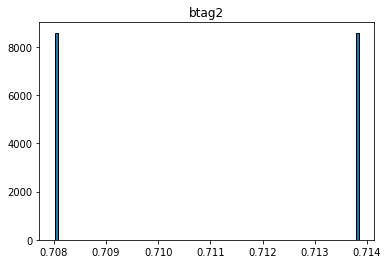

In [137]:
#DEBUGGINGGGGG


#dijet mass
dfcut = df_qq.query('xmj1p2>40 & btag1>0.5 & btag2>0.5 & ucsdbt0>2.5 & acoll<65*2*3.1415926/360')
#mass recoiling to do

#encm
varlist = ['btag2',]
bins = [100]

dfcut = df_list_cut[2]
for varname in varlist:
    index = varlist.index(varname)
    plt.hist(dfcut[varname], bins=bins[index], ec="black", histtype="stepfilled", density=1)
    plt.title(varname)
    plt.show()

1555670188.0388126
